# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [99]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
from pyspark.sql.functions import max as max_

import datetime
import pandas as pd

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
dfRaw = spark.read.json('mini_sparkify_event_data.json')

In [4]:
dfRaw.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
dfRaw.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
dfRaw.describe("userId").show()
dfRaw.describe("sessionId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [7]:
print(f'# of null userIds: {dfRaw.filter(dfRaw.userId.isNull()).count()}')
print(f'# of null sessionIds: {dfRaw.filter(dfRaw.sessionId.isNull()).count()}')

# of null userIds: 0
# of null sessionIds: 0


In [8]:
print(f'# of empty userIds: {dfRaw.filter(dfRaw.userId == "").count()}')
print(f'# of empty sessionIds: {dfRaw.filter(dfRaw.sessionId == "").count()}')

# of empty userIds: 8346
# of empty sessionIds: 0


In [9]:
emptyUserId = dfRaw.filter(dfRaw.userId == "")

In [10]:
dfRaw.groupby(dfRaw.auth).count().show()
emptyUserId.groupby(emptyUserId.auth).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [11]:
dfRaw.groupby(dfRaw.page).count().show()
emptyUserId.groupby(emptyUserId.page).count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
| 

In [12]:
validUsers = dfRaw.filter(dfRaw.userId != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))

In [14]:
validUsers = validUsers.withColumn("hour", get_hour(validUsers.ts).cast("float"))
validUsers = validUsers.withColumn("date", get_date(validUsers.ts))

In [15]:
churnUsers = validUsers.filter(validUsers.page == 'Cancellation Confirmation').select('userId')
churnUsers = churnUsers.withColumn("churn", lit(1))
churnUsers=churnUsers.select(col("userId").alias("userId_a"), col("churn"))

validUsers = validUsers.join(churnUsers, validUsers.userId == churnUsers.userId_a, 'left')
validUsers = validUsers.drop(validUsers.userId_a)

In [16]:
downUsers = validUsers.filter(validUsers.page == 'Downgrade').select('userId')
downUsers = downUsers.withColumn("downgrade", lit(1))
downUsers=downUsers.select(col("userId").alias("userId_b"), col("downgrade"))

validUsers = validUsers.join(downUsers, validUsers.userId == downUsers.userId_b, 'left')
validUsers = validUsers.drop(validUsers.userId_b)

In [17]:
churnedDf = validUsers.filter(validUsers.churn == 1).select(['userId','gender','page','hour','date', 'downgrade'])
nChurnedDf = validUsers.filter(validUsers.churn.isNull()).select(['userId','gender','page','hour','date', 'downgrade'])

### Analise de musicas

In [18]:
churnedSongs = churnedDf.filter(churnedDf.page == 'NextSong')
nChurnedSongs = nChurnedDf.filter(nChurnedDf.page == 'NextSong')

In [19]:
numUsersChurn = churnUsers.count()
numUsersNChurn = nChurnedSongs.select(nChurnedSongs.userId).dropDuplicates().count()

In [20]:
# média de musicas por usuario que churn
churnedSongs.count() / numUsersChurn

9548.461538461539

In [21]:
# média de musicas por usuario que não churn
nChurnedSongs.count() / numUsersNChurn

24861.456647398845

#### Analise de churned por data

In [22]:
songByDay = churnedSongs.groupby(churnedSongs.date).count().orderBy(churnedSongs.date).select(col("date").alias("date_a"), col("count").alias("qtdSongs"))
userByDay = churnedSongs.select(['date','userId']).dropDuplicates().groupby(churnedSongs.date).count().orderBy(churnedSongs.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [23]:
songsByUserDay = songByDay.join(userByDay, songByDay.date_a == userByDay.date_b, 'left').orderBy(songByDay.date_a)
songsByUserDay = songsByUserDay.withColumn("songs_user", songsByUserDay.qtdSongs/songsByUserDay.qtdUsers).drop(songsByUserDay.date_b)

In [24]:
pdSongsDay = songsByUserDay.toPandas()

In [25]:
pdSongsDay.head()

,date_a,qtdSongs,qtdUsers,songs_user
0,2018-10-01,13173,18,731.833333
1,2018-10-02,16126,19,848.736842
2,2018-10-03,13000,21,619.047619
3,2018-10-04,13663,20,683.150000
4,2018-10-05,20095,18,1116.388889


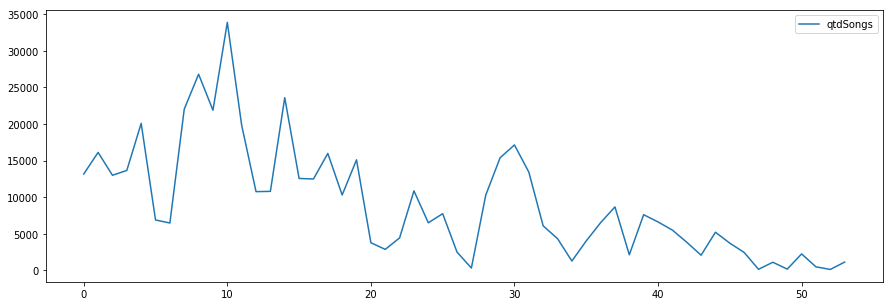

In [39]:
pdSongsDay[['date_a','qtdSongs']].plot.line(figsize=(15,5))

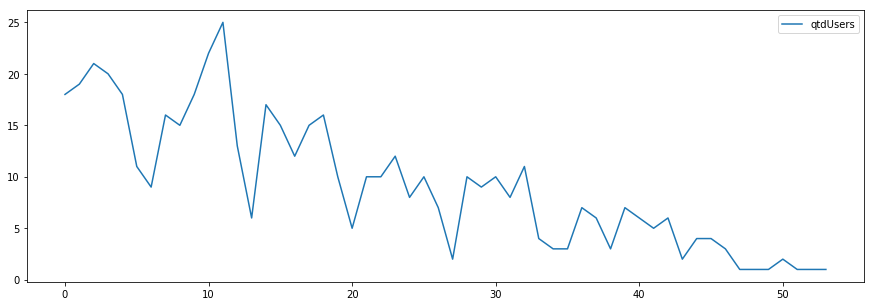

In [27]:
pdSongsDay[['date_a','qtdUsers']].plot.line(figsize=(15,5))

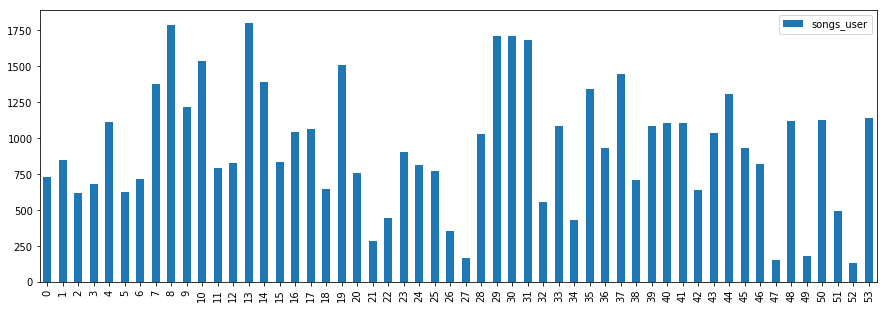

In [28]:
pdSongsDay[['date_a','songs_user']].plot.bar(figsize=(15,5))

#### Analise de não churned por data

In [47]:
songByDay = nChurnedSongs.groupby(nChurnedSongs.date).count().orderBy(nChurnedSongs.date).select(col("date").alias("date_a"), col("count").alias("qtdSongs"))
userByDay = nChurnedSongs.select(['date','userId']).dropDuplicates().groupby(nChurnedSongs.date).count().orderBy(nChurnedSongs.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [48]:
songsByUserDay = songByDay.join(userByDay, songByDay.date_a == userByDay.date_b, 'left').orderBy(songByDay.date_a)
songsByUserDay = songsByUserDay.withColumn("songs_user", songsByUserDay.qtdSongs/songsByUserDay.qtdUsers).drop(songsByUserDay.date_b)

In [49]:
pdSongsDay = songsByUserDay.toPandas()

In [50]:
pdSongsDay.head()

,date_a,qtdSongs,qtdUsers,songs_user
0,2018-10-01,49519,47,1053.595745
1,2018-10-02,47215,36,1311.527778
2,2018-10-03,40386,44,917.863636
3,2018-10-04,58138,46,1263.869565
4,2018-10-05,52703,44,1197.795455


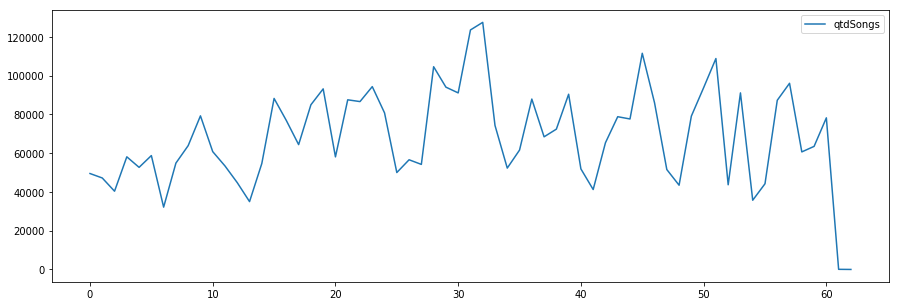

In [51]:
pdSongsDay[['date_a','qtdSongs']].plot.line(figsize=(15,5))

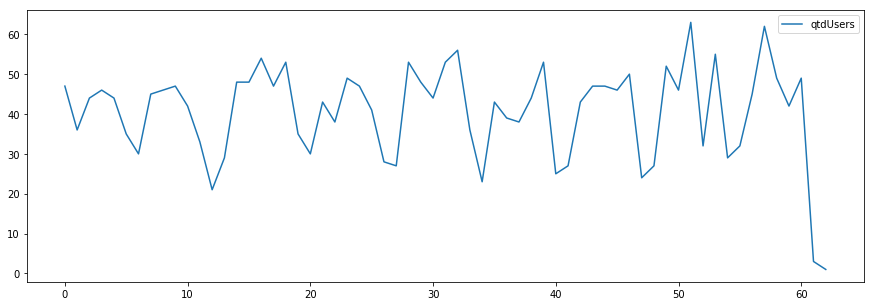

In [52]:
pdSongsDay[['date_a','qtdUsers']].plot.line(figsize=(15,5))

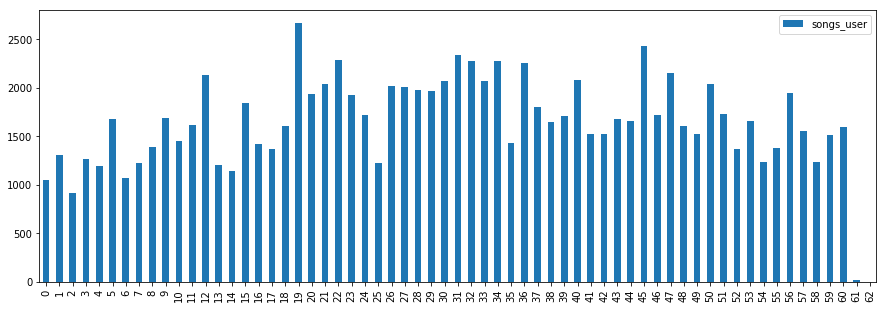

In [53]:
pdSongsDay[['date_a','songs_user']].plot.bar(figsize=(15,5))

#### Analise de churned por hora

In [29]:
songByHour = churnedSongs.groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_a"), col("count").alias("qtdSongs"))
userByHour = churnedSongs.select(['hour','userId']).dropDuplicates().groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_b"), col("count").alias("qtdUsers"))

In [30]:
songsByUserHour = songByHour.join(userByHour, songByHour.hour_a == userByHour.hour_b, 'left').orderBy(songByHour.hour_a)
songsByUserHour = songsByUserHour.withColumn("songs_user", songsByUserHour.qtdSongs/songsByUserHour.qtdUsers).drop(songsByUserHour.hour_b)

In [31]:
pdSongsHour = songsByUserHour.toPandas()

In [40]:
pdSongsHour.head()

,hour_a,qtdSongs,qtdUsers,songs_user
0,0.0,23854,36,662.611111
1,1.0,20669,34,607.911765
2,2.0,19211,36,533.638889
3,3.0,18254,32,570.437500
4,4.0,17885,35,511.000000


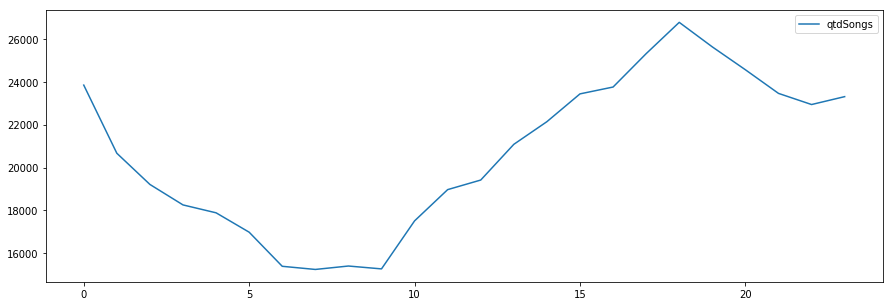

In [44]:
pdSongsHour[['qtdSongs']].plot.line(figsize=(15,5))

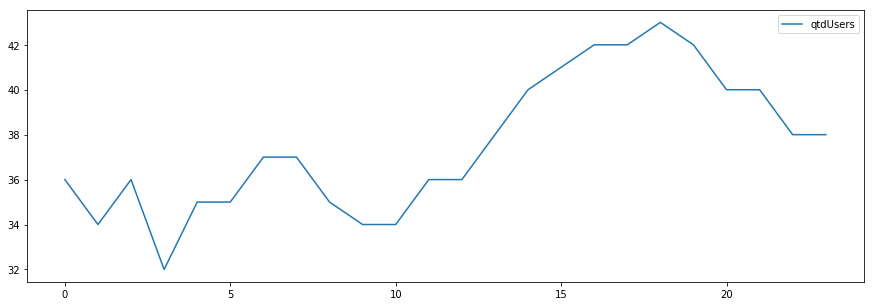

In [45]:
pdSongsHour[['qtdUsers']].plot.line(figsize=(15,5))

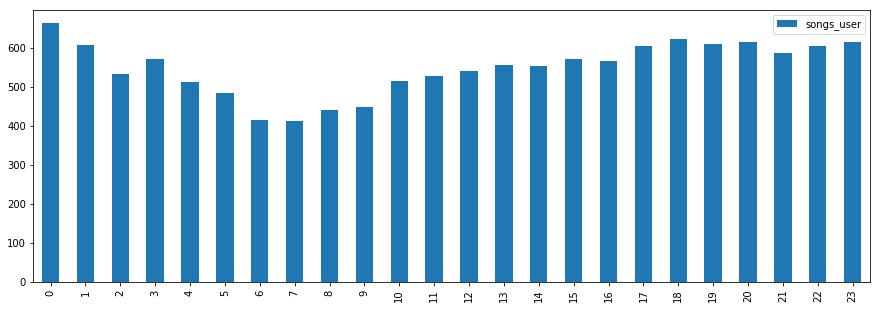

In [46]:
pdSongsHour[['songs_user']].plot.bar(figsize=(15,5))

#### Analise de nao churned por hora

In [54]:
songByHour = nChurnedSongs.groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_a"), col("count").alias("qtdSongs"))
userByHour = nChurnedSongs.select(['hour','userId']).dropDuplicates().groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_b"), col("count").alias("qtdUsers"))

In [55]:
songsByUserHour = songByHour.join(userByHour, songByHour.hour_a == userByHour.hour_b, 'left').orderBy(songByHour.hour_a)
songsByUserHour = songsByUserHour.withColumn("songs_user", songsByUserHour.qtdSongs/songsByUserHour.qtdUsers).drop(songsByUserHour.hour_b)

In [56]:
pdSongsHour = songsByUserHour.toPandas()

In [57]:
pdSongsHour.head()

,hour_a,qtdSongs,qtdUsers,songs_user
0,0.0,164482,137,1200.598540
1,1.0,154654,138,1120.681159
2,2.0,154205,140,1101.464286
3,3.0,153909,139,1107.258993
4,4.0,152119,137,1110.357664


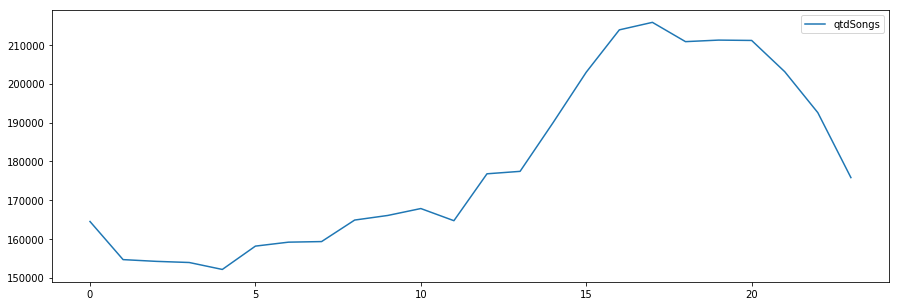

In [58]:
pdSongsHour[['qtdSongs']].plot.line(figsize=(15,5))

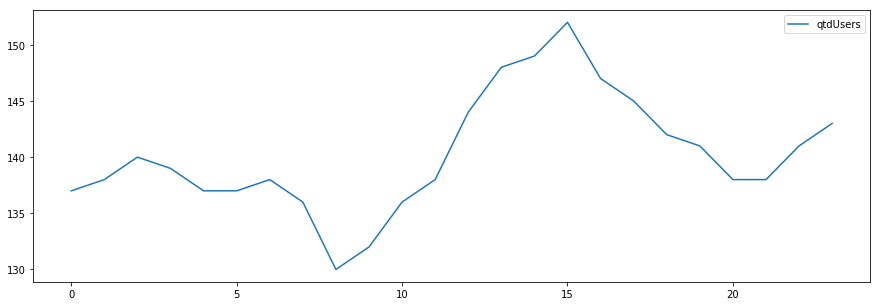

In [59]:
pdSongsHour[['qtdUsers']].plot.line(figsize=(15,5))

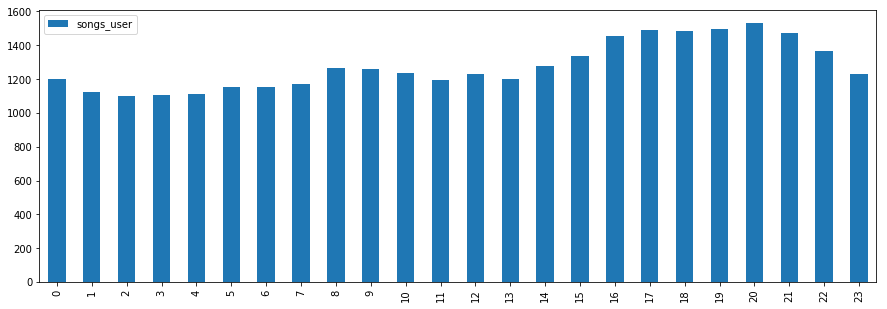

In [60]:
pdSongsHour[['songs_user']].plot.bar(figsize=(15,5))

#### Analise de Thumbs Up/Down

In [33]:
churnedTU = churnedDf.filter(churnedDf.page == 'Thumbs Up')
nChurnedTU = nChurnedDf.filter(nChurnedDf.page == 'Thumbs Up')

churnedTD = churnedDf.filter(churnedDf.page == 'Thumbs Down')
nChurnedTD = nChurnedDf.filter(nChurnedDf.page == 'Thumbs Down')

In [34]:
# média de likes por usuario que churn
churnedTU.count() / numUsersChurn

492.21153846153845

In [35]:
# média de likes por usuario que nao churn
nChurnedTU.count() / numUsersNChurn

1333.6242774566474

In [36]:
# média de dislikes por usuario que churn
churnedTD.count() / numUsersChurn

116.11538461538461

In [37]:
# média de dislikes por usuario que nao churn
nChurnedTD.count() / numUsersNChurn

267.01734104046244

#### Analise de TU de churned por data

In [61]:
thumbUpByDay = churnedTU.groupby(churnedTU.date).count().orderBy(churnedTU.date).select(col("date").alias("date_a"), col("count").alias("qtdTU"))
userByDay = churnedTU.select(['date','userId']).dropDuplicates().groupby(churnedTU.date).count().orderBy(churnedTU.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [62]:
thumbUpByUserDay = thumbUpByDay.join(userByDay, thumbUpByDay.date_a == userByDay.date_b, 'left').orderBy(thumbUpByDay.date_a)
thumbUpByUserDay = thumbUpByUserDay.withColumn("tu_user", thumbUpByUserDay.qtdTU/thumbUpByUserDay.qtdUsers).drop(thumbUpByUserDay.date_b)

In [63]:
pdTUDay = thumbUpByUserDay.toPandas()

In [65]:
pdTUDay.head()

,date_a,qtdTU,qtdUsers,tu_user
0,2018-10-01,593,14,42.357143
1,2018-10-02,645,17,37.941176
2,2018-10-03,413,14,29.500000
3,2018-10-04,670,15,44.666667
4,2018-10-05,1095,14,78.214286


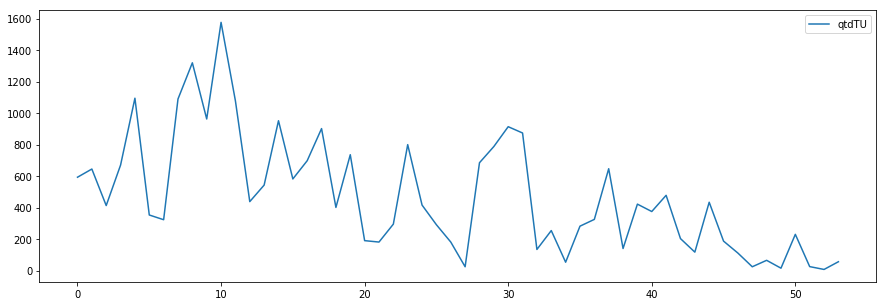

In [67]:
pdTUDay[['date_a','qtdTU']].plot.line(figsize=(15,5))

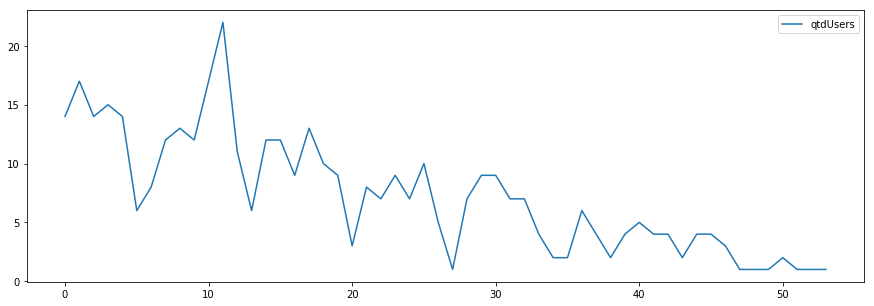

In [68]:
pdTUDay[['date_a','qtdUsers']].plot.line(figsize=(15,5))

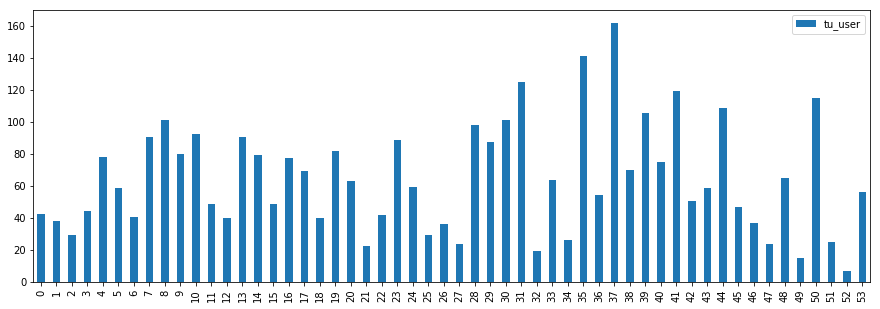

In [69]:
pdTUDay[['date_a','tu_user']].plot.bar(figsize=(15,5))

#### Analise de TU de nao churned por data

In [70]:
thumbUpByDay = nChurnedTU.groupby(churnedTU.date).count().orderBy(churnedTU.date).select(col("date").alias("date_a"), col("count").alias("qtdTU"))
userByDay = nChurnedTU.select(['date','userId']).dropDuplicates().groupby(churnedTU.date).count().orderBy(churnedTU.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [71]:
thumbUpByUserDay = thumbUpByDay.join(userByDay, thumbUpByDay.date_a == userByDay.date_b, 'left').orderBy(thumbUpByDay.date_a)
thumbUpByUserDay = thumbUpByUserDay.withColumn("tu_user", thumbUpByUserDay.qtdTU/thumbUpByUserDay.qtdUsers).drop(thumbUpByUserDay.date_b)

In [72]:
pdTUDay = thumbUpByUserDay.toPandas()

In [73]:
pdTUDay.head()

,date_a,qtdTU,qtdUsers,tu_user
0,2018-10-01,2452,35,70.057143
1,2018-10-02,2734,29,94.275862
2,2018-10-03,2544,33,77.090909
3,2018-10-04,3718,31,119.935484
4,2018-10-05,3567,29,123.000000


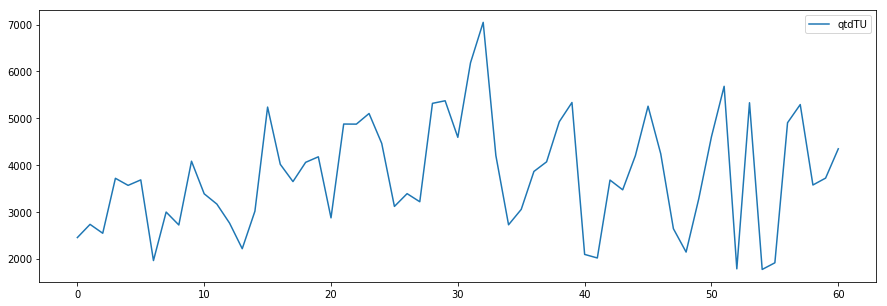

In [74]:
pdTUDay[['date_a','qtdTU']].plot.line(figsize=(15,5))

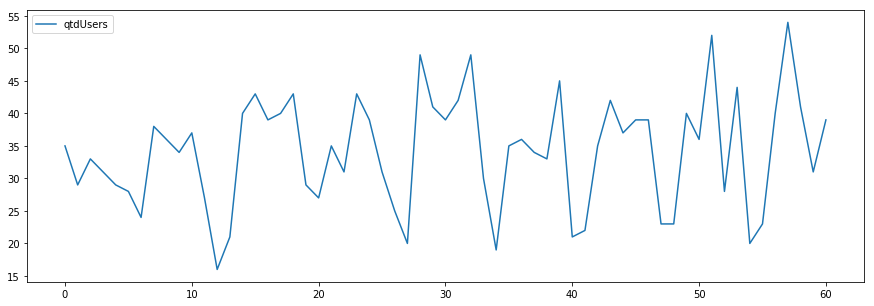

In [75]:
pdTUDay[['date_a','qtdUsers']].plot.line(figsize=(15,5))

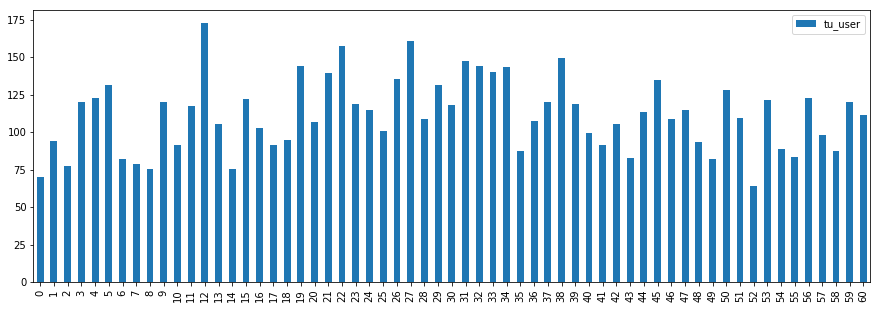

In [76]:
pdTUDay[['date_a','tu_user']].plot.bar(figsize=(15,5))

#### Analise de downgrade

In [77]:
numChurnedDown = churnedDf.filter(churnedDf.page == 'Downgrade').select(churnedDf.userId).dropDuplicates().count()
numNChurnedDown = nChurnedDf.filter(nChurnedDf.page == 'Downgrade').select(nChurnedDf.userId).dropDuplicates().count()

In [78]:
numChurnedDown / numUsersChurn

0.6730769230769231

In [79]:
numNChurnedDown / numUsersNChurn

0.6878612716763006

In [101]:
# buscar diferenca entre dia do downgrade para dia do cancelamento

In [100]:
cancelDate = churnedDf.filter(churnedDf.page == 'Cancellation Confirmation').select([churnedDf.userId, churnedDf.date]).dropDuplicates().orderBy(churnedDf.userId)
downDate = churnedDf.filter(churnedDf.page == 'Downgrade').select([churnedDf.userId, churnedDf.date])
downDate = downDate.groupby(downDate.userId).agg(max_("datetime")).show()

AnalysisException: "cannot resolve '`datetime`' given input columns: [userId, date];;\n'Aggregate [userId#23], [userId#23, max('datetime) AS max(datetime)#1634]\n+- Project [userId#23, date#447]\n   +- Filter (page#16 = Downgrade)\n      +- Project [userId#23, gender#9, page#16, hour#426, date#447, downgrade#563]\n         +- Filter (churn#469 = 1)\n            +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, date#447, churn#469, downgrade#563]\n               +- Join LeftOuter, (userId#23 = userId_b#566)\n                  :- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, date#447, churn#469]\n                  :  +- Join LeftOuter, (userId#23 = userId_a#472)\n                  :     :- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, <lambda>(ts#21L) AS date#447]\n                  :     :  +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, cast(<lambda>(ts#21L) as float) AS hour#426]\n                  :     :     +- Filter NOT (userId#23 = )\n                  :     :        +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n                  :     +- Project [userId#23 AS userId_a#472, churn#469]\n                  :        +- Project [userId#23, 1 AS churn#469]\n                  :           +- Project [userId#23]\n                  :              +- Filter (page#16 = Cancellation Confirmation)\n                  :                 +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, <lambda>(ts#21L) AS date#447]\n                  :                    +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, cast(<lambda>(ts#21L) as float) AS hour#426]\n                  :                       +- Filter NOT (userId#23 = )\n                  :                          +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n                  +- Project [userId#23 AS userId_b#566, downgrade#563]\n                     +- Project [userId#23, 1 AS downgrade#563]\n                        +- Project [userId#23]\n                           +- Filter (page#16 = Downgrade)\n                              +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, date#447, churn#469]\n                                 +- Join LeftOuter, (userId#23 = userId_a#472)\n                                    :- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, <lambda>(ts#21L) AS date#447]\n                                    :  +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, cast(<lambda>(ts#21L) as float) AS hour#426]\n                                    :     +- Filter NOT (userId#23 = )\n                                    :        +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n                                    +- Project [userId#23 AS userId_a#472, churn#469]\n                                       +- Project [userId#23, 1 AS churn#469]\n                                          +- Project [userId#23]\n                                             +- Filter (page#16 = Cancellation Confirmation)\n                                                +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#426, <lambda>(ts#21L) AS date#447]\n                                                   +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, cast(<lambda>(ts#21L) as float) AS hour#426]\n                                                      +- Filter NOT (userId#23 = )\n                                                         +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n"

In [94]:
dfRaw.filter(dfRaw.page == 'Downgrade').filter(dfRaw.userId == '100007').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|     page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Piper|     F|            8|    Cook|  null| paid|Little Rock-North...|   GET|Downgrade|1533522419000|       34|null|   200|1538467035000|"Mozilla/5.0 (Win...|100007|
|  null|Logged In|    Piper|     F|           54|    Cook|  null| paid|Little Rock-North...|   GET|Downgrade|1533522419000|       34|null|   200|1538475302000|"Mozilla/5.0 (Win...|100007|
|  null|Logged In|    Piper|     F|          109|    Cook|  

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.